# Convolutional Neural Networks for Regression

**This notebook shows how to create a CNN model for regression with TensorFlow 2 and Keras**

## The Data

Input images:
- RGB ([B4,B3,B2]) bands of the [**USGS Landsat 8 Surface Reflectance Tier 1**](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR) dataset-

Output image:
- Impervious band of the [**NLCD: USGS National Land Cover Database**](https://developers.google.com/earth-engine/datasets/catalog/USGS_NLCD).

**Information**

In this tutorial we will infer the percent of the pixel covered by developed impervious surface from Lansat 8 RGB images.

The `TFRecords` have been created and exported to Google Cloud Store in this [notebook](../0-TFRecords/2-TFRecords_from_GEE.ipynb/#impervious).

## Table of Contents
- ### [Python libraries](#libraries)
- ### [Data exploration](#exploration)
    - #### [Read tha data](#read)
    - #### [Visualize the data](#visualize)
- ### [Create `tf.data.Dataset` from TFRecords](#dataset)
- ### [Create the model](#model)
- ### [Train the model](#train)
- ### [Evaluate the model](#evaluate)
- ### [Predictions](#predictions)

<a id='libraries'></a>
## Python libraries

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

<a id='exploration'></a>
## Data exploration

<a id='read'></a>
### Read the data

In [ ]:
from google.cloud import storage

In [ ]:
client = storage.Client()
bucket_name = 'geo-ai'
bucket = client.get_bucket(bucket_name)

**Get the list of files in the bucket**

In [ ]:
folder = 'Impervious/Data'
file_type = 'tfrecord.gz'

In [ ]:
filelist = []
blobs = bucket.list_blobs(prefix=folder)
for blob in blobs:
    filelist.append(blob.name)   

files = [i for i in filelist if file_type in i]
files = ['gs://'+bucket_name+'/'+i for i in files]

**Get number of records**

In [85]:
nRecords_train = 0
nRecords_test = 0

glob_train = 'gs://geo-ai/Impervious/Data/training_patches' + '*'
glob_test = 'gs://geo-ai/Impervious/Data/test_patches' + '*'

for n, glob in enumerate([glob_train, glob_test]):
    glob = tf.compat.v1.io.gfile.glob(glob)

    for record in tf.data.TFRecordDataset(glob, compression_type='GZIP'):
        example = tf.train.Example()
        example.ParseFromString(record.numpy())
        
        if n == 0:
            nRecords_train += 1
        else:
            nRecords_test += 1
    
print('Number of training records:', nRecords_train)
print('Number of test records:', nRecords_test)

Number of training records: 6000
Number of test records: 2000


<a id='visualize'></a>
### Visualize the data

**Read example record**

In [24]:
for record in tf.data.TFRecordDataset(glob, compression_type='GZIP').take(1):
    example = tf.train.Example()
    example.ParseFromString(record.numpy())

bands = list(dict(example.features.feature).keys())
print('Bands:', bands)

Bands: ['vis-green', 'vis-gray', 'vis-red', 'vis-blue']


Text(0.5, 1.0, 'Impervious')

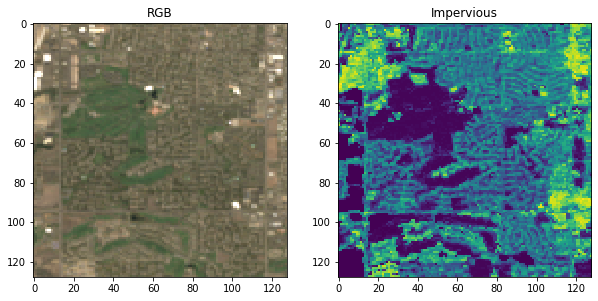

In [61]:
bands = [['vis-red', 'vis-green', 'vis-blue'],['vis-gray']]

input_image = np.concatenate([np.array(example.features.feature[i].float_list.value).reshape(128,128,1) for i in bands[0]], axis=2)
output_image = np.concatenate([np.array(example.features.feature[i].float_list.value).reshape(128,128) for i in bands[1]], axis=1)

fig, ax = plt.subplots(1,len(bands), figsize=(5*len(bands),5))
ax[0].imshow(input_image.astype(int))
ax[0].set_title('RGB')
ax[1].imshow(output_image)
ax[1].set_title('Impervious')

<a id='dataset'></a>
## Create `tf.data.Dataset` from TFRecords

**Parse function for data preprocessing**

In [75]:
def parse_function(proto):
    
    # Define your tfrecord 
    bands_input = ['vis-red', 'vis-green', 'vis-blue']
    columns_input = [tf.io.FixedLenFeature([128,128,1], tf.float32) for i in bands_input]

    bands_output = ['vis-gray']
    columns_output = [tf.io.FixedLenFeature([128,128,1], tf.float32) for i in bands_output]

    bands = bands_input + bands_output
    columns = columns_input + columns_output
    features = dict(zip(bands, columns))
    
    # Load one example
    parsed_features = tf.io.parse_single_example(proto, features)
    
    # Separate the output images from the input images
    label = parsed_features.pop('vis-gray')
    image = tf.concat([parsed_features[i] for i in bands_input], axis=2)
    
    # Normalize
    image = tf.divide(image, 255.0)
    label = tf.divide(label, 255.0)
    
    return image, label

**Prepare train and test datasets using tf.data**

In [76]:
def create_dataset(glob, shuffle_size, batch_size):
    
    glob = tf.compat.v1.io.gfile.glob(glob)
        
    dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
    
    # Maps the preprocessing function. You can set the number of parallel loaders here
    dataset = dataset.map(parse_function, num_parallel_calls=8)
    
    # This dataset will go on forever
    dataset = dataset.repeat()
    
    # Set the number of datapoints you want to load and shuffle 
    dataset = dataset.shuffle(shuffle_size)
    
    # Set the batchsize
    dataset = dataset.batch(batch_size)
    
    return dataset

In [93]:
batch_size = 32
dataset_train = create_dataset(glob = 'gs://geo-ai/Impervious/Data/training_patches' + '*', shuffle_size=nRecords_train, batch_size=batch_size)
dataset_test = create_dataset(glob = 'gs://geo-ai/Impervious/Data/test_patches' + '*', shuffle_size=nRecords_test, batch_size=batch_size)

In [78]:
dataset_train

<BatchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>

<a id='model'></a>
## Create the model

Here we use the Keras implementation of the [DeepVel](https://www.aanda.org/articles/aa/pdf/2017/08/aa30783-17.pdf) model.  The DeepVel model will be trained with images of 128 x 128 pixel in size, but given the fully convolutional character of the network we could applied it seamlessly to any size of images. We will use mean squared error loss on the sigmoidal output since we are treating this as a regression problem.  Since impervious surface fraction is constrained to [0,1], with many values close to zero or one, a saturating activation function is suitable here. 

In [79]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Add
from tensorflow.python.keras.layers.core import Layer, Activation, Reshape
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D

In [89]:
def residual(inputs, filter_size, kernel):
    x = Conv2D(filter_size, kernel, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filter_size, kernel, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Add()([x, inputs])  
    return x

def create_model(inputShape, output_activation='sigmoid'):
    """
    DeepVel model
    ----------
    inputShape : tuple
        Tuple with the dimensions of the input data (ny, nx, nBands). 
    nClasses : int
            Number of classes.
    """

    filter_size = 64
    kernel = (3, 3)        
    n_residual_layers = 5   

    inputs = Input(shape=inputShape, name='image')  
    conv = Conv2D(filter_size, kernel, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)   
    x = residual(conv, filter_size, kernel)
    for i in range(n_residual_layers):
        x = residual(x, filter_size, kernel)    
    x = Conv2D(filter_size, kernel, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Add()([x, conv])    

    outputs = Conv2D(1, (1, 1), activation=output_activation, padding='same', kernel_initializer='he_normal', name= 'output')(x) 
    
    model = Model(inputs=inputs, outputs=outputs, name='deepvel')
    
    
    # Compile model
    model.compile(loss='MSE',
                  optimizer='adam', 
                  metrics=['RootMeanSquaredError'])

    return model

In [90]:
model = create_model(inputShape = input_image.shape, output_activation='sigmoid')
print('Output shape:', model.output_shape)

Output shape: (None, 128, 128, 1)


In [91]:
model.summary()

Model: "deepvel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 128, 128, 64) 1792        image[0][0]                      
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_56[0][0]                  
__________________________________________________________________________________________________
batch_normalization_52 (BatchNo (None, 128, 128, 64) 256         conv2d_57[0][0]                  
____________________________________________________________________________________________

<a id='train'></a>
## Train the model

In [83]:
from tensorflow.keras.callbacks import EarlyStopping

In [84]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [94]:
nEpoch = 25
nStep_train = (int)(nRecords_train/batch_size)
nStep_test = (int)(nRecords_test/batch_size)

In [95]:
model.fit(dataset_train, 
          epochs=nEpoch, 
          validation_data=dataset_test, 
          steps_per_epoch=nStep_train, 
          validation_steps=nStep_test,
          callbacks=[early_stop])

Train for 187 steps, validate for 62 steps
Epoch 1/25
  3/187 [..............................] - ETA: 3:52:56 - loss: 0.2452 - RootMeanSquaredError: 0.4952

KeyboardInterrupt: 

- **Plot loss**

In [ ]:
metrics = pd.DataFrame(model.history.history)
metrics[['loss', 'val_loss']].plot()

- **Plot the Root Mean Squared Error**

In [ ]:
metrics[['RootMeanSquaredError', 'val_RootMeanSquaredError']].plot()

<a id='evaluate'></a>
## Evaluate the model

**Root mean square error**

In [ ]:
predictions = model.predict(dataset_test)

<a id='predictions'></a>
## Predictions